In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader

## Load the train and validation datasets

In [2]:
root = '../KuaiRec 2.0/'

# Training data
train = pd.read_csv(root + "data_exports/joined_train_data_segmented.csv")

# Validation data
# val = pd.read_csv(root + "data_exports/joined_val_data.csv")

# Test data
# test = pd.read_csv(root + "test_data.csv")

print(f'Total number of training data: {len(train)}')
# print(f'Total number of validation data: {len(val)}')
# print(f'Total number of test data: {len(test)}')

Total number of training data: 2552082


In [3]:
train.head()

,user_id,video_id,time,watch_ratio,user_active_degree,is_lowactive_period,is_live_streamer,is_video_author,follow_user_num,fans_user_num,...,avg_daily_watch_time,top_3_categories,cluster,News_Politics,Auto_Tech,Lifestyle,Sports_Fitness,Entertainment,Culture,Others
0,14,148,2020-07-05 05:27:48.378,0.722103,full_active,0,0,1,73,6,...,8.360719e+12,"['Car', 'Pets', 'Real estate家居']",0,0,1,1,0,0,0,1
1,14,183,2020-07-05 05:28:00.057,1.907377,full_active,0,0,1,73,6,...,8.360719e+12,"['Car', 'Pets', 'Real estate家居']",0,0,1,1,0,0,0,1
2,14,3649,2020-07-05 05:29:09.479,2.063311,full_active,0,0,1,73,6,...,8.360719e+12,"['Car', 'Pets', 'Real estate家居']",0,0,1,1,0,0,0,1
3,14,5262,2020-07-05 05:30:43.285,0.566388,full_active,0,0,1,73,6,...,8.360719e+12,"['Car', 'Pets', 'Real estate家居']",0,0,1,1,0,0,0,1
4,14,8234,2020-07-05 05:35:43.459,0.418364,full_active,0,0,1,73,6,...,8.360719e+12,"['Car', 'Pets', 'Real estate家居']",0,0,1,1,0,0,0,1


In [4]:
# Segregate by 
# 'cluster'

# One hot encode
# 'user_active_degree', 'time_period'

# Embedding?
# 'video_tag_name'

# Remove
# 'author_id', 'video_type', 
# 'manual_cover_text',
# 'caption', 'topic_tag', 'first_level_category_name',
# 'second_level_category_name', 'third_level_category_name',
# 'english_caption', 'english_first_level_category_name',
# 'english_second_level_category_name',
# 'english_third_level_category_name', 'english_topic_tag'
# 'top_3_categories' (use the OHE categories)

# To incorporate (time decay)
# 'time'

## Preprocessing for feeding into Neural Network portion of NCF

In [5]:
# Convert type to datetime
train['time'] = pd.to_datetime(train['time'])
# val['time'] = pd.to_datetime(val['time'])
# test['time'] = pd.to_datetime(test['time'])

### One hot encode categorical variables

In [6]:
# One hot encode 'user_active_degree', 'time_period'
train_processed = pd.get_dummies(train, columns=['user_active_degree', 'time_period'])

# Remove the column for user_active_degree = UNKNOWN
train_processed = train_processed.drop(columns=['user_active_degree_UNKNOWN'])

In [7]:
# Remove 'author_id', 'video_type' (all 'NORMAL') and video caption/category columns. For video features, we are using the 
# regrouped category mappings which we have already one hot encoded from the feature engineering stage

train_processed = train_processed.drop(columns=['author_id', 'video_type', 
                                    'video_tag_name', 
                                    'manual_cover_text', 'caption', 'topic_tag', 
                                    'first_level_category_name', 'second_level_category_name', 'third_level_category_name',
                                    'english_caption', 'english_first_level_category_name',
                                    'english_second_level_category_name',
                                    'english_third_level_category_name', 'english_topic_tag',
                                    'top_3_categories'
                                    ])

### Scale continuous variables

In [8]:
train_processed.columns

Index(['user_id', 'video_id', 'time', 'watch_ratio', 'is_lowactive_period',
       'is_live_streamer', 'is_video_author', 'follow_user_num',
       'fans_user_num', 'friend_user_num', 'register_days', 'video_duration',
       'show_cnt', 'play_cnt', 'play_duration', 'like_cnt', 'comment_cnt',
       'share_cnt', 'follow_cnt', 'collect_cnt', 'is_new_user',
       'total_connections', 'is_content_creator', 'hour', 'day_of_week',
       'watch_frequency', 'is_weekend_interaction', 'is_weekend',
       'count_afternoon_views', 'count_evening_views', 'count_midnight_views',
       'count_morning_views', 'avg_daily_watch_time', 'cluster',
       'News_Politics', 'Auto_Tech', 'Lifestyle', 'Sports_Fitness',
       'Entertainment', 'Culture', 'Others', 'user_active_degree_full_active',
       'user_active_degree_high_active', 'user_active_degree_middle_active',
       'time_period_afternoon', 'time_period_evening', 'time_period_midnight',
       'time_period_morning'],
      dtype='object')

In [9]:
# We can see that the values are all on different scales. For example, follow_user_num is in the tens-thousands while like_cnt can range form millions to billions. This will affect the training of the model, therefore scaling is needed

train_processed[['follow_user_num',
       'fans_user_num', 'friend_user_num', 'register_days', 'video_duration',
       'show_cnt', 'play_cnt', 'play_duration', 'like_cnt', 'comment_cnt',
       'share_cnt', 'follow_cnt', 'collect_cnt', 'count_afternoon_views', 'count_evening_views', 'count_midnight_views',
       'count_morning_views', 'avg_daily_watch_time']].describe()

,follow_user_num,fans_user_num,friend_user_num,register_days,video_duration,show_cnt,play_cnt,play_duration,like_cnt,comment_cnt,share_cnt,follow_cnt,collect_cnt,count_afternoon_views,count_evening_views,count_midnight_views,count_morning_views,avg_daily_watch_time
count,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06
mean,5.381411e+01,3.872561e+00,1.331606e+00,2.653341e+02,1.164791e+04,6.959049e+06,7.052437e+06,1.325106e+11,2.044780e+05,8.935899e+03,3.805251e+03,2.093272e+04,2.858760e+02,4.658341e+02,2.809108e+02,4.579366e+02,6.100598e+02,8.062631e+12
std,1.418902e+02,9.716679e+00,4.924868e+00,2.640708e+02,1.344116e+04,9.275605e+06,9.511481e+06,2.782091e+11,3.209431e+05,2.111983e+04,1.269530e+04,6.331006e+04,1.337505e+03,2.844922e+02,2.385123e+02,4.339834e+02,3.305712e+02,7.068827e+11
min,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,3.066000e+03,6.440000e+02,3.310000e+02,1.889531e+06,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.632392e+12
25%,7.000000e+00,0.000000e+00,0.000000e+00,1.190000e+02,7.333000e+03,8.329130e+05,7.629220e+05,8.757655e+09,1.552800e+04,3.450000e+02,6.400000e+01,1.002000e+03,5.000000e+00,2.490000e+02,8.400000e+01,5.300000e+01,3.740000e+02,7.686325e+12
50%,1.500000e+01,1.000000e+00,0.000000e+00,2.000000e+02,9.383000e+03,3.127692e+06,3.071419e+06,3.828763e+10,7.359000e+04,2.171000e+03,4.140000e+02,4.968000e+03,2.800000e+01,4.440000e+02,2.250000e+02,3.560000e+02,5.690000e+02,8.158000e+12
75%,4.300000e+01,4.000000e+00,1.000000e+00,3.020000e+02,1.150000e+04,9.372330e+06,9.544620e+06,1.407297e+11,2.512090e+05,8.918000e+03,2.275000e+03,1.797800e+04,1.330000e+02,6.560000e+02,4.190000e+02,7.480000e+02,8.060000e+02,8.518700e+12
max,1.811000e+03,2.510000e+02,7.100000e+01,2.002000e+03,2.945200e+05,6.525508e+07,6.479578e+07,4.888408e+12,2.762854e+06,3.383650e+05,2.061050e+05,1.215372e+06,2.919700e+04,1.477000e+03,1.435000e+03,1.852000e+03,1.727000e+03,1.277244e+13


In [10]:
scaler = StandardScaler()

# We are not using 'play_duration' as it is highly correlated to target variable 'watch_ratio' (watch_ratio = play_duration / video_duration)
columns_to_scale = ['follow_user_num',
       'fans_user_num', 'friend_user_num', 'register_days', 'video_duration',
       'show_cnt', 'play_cnt', 
      #  'play_duration', 
       'like_cnt', 'comment_cnt',
       'share_cnt', 'follow_cnt', 'collect_cnt', 
       'total_connections',
       'watch_frequency', 
       'count_afternoon_views', 'count_evening_views', 'count_midnight_views',
       'count_morning_views', 
       'avg_daily_watch_time', 
       ]

train_processed[columns_to_scale] = scaler.fit_transform(train_processed[columns_to_scale])

In [11]:
train_processed[['follow_user_num',
       'fans_user_num', 'friend_user_num', 'register_days', 'video_duration',
       'show_cnt', 'play_cnt', 'like_cnt', 'comment_cnt',
       'share_cnt', 'follow_cnt', 'collect_cnt', 'count_afternoon_views', 'count_evening_views', 'count_midnight_views',
       'count_morning_views', 'avg_daily_watch_time']].describe()

# We now see that the mean of all the columns is (close to) 0 and the standard deviation is 1

,follow_user_num,fans_user_num,friend_user_num,register_days,video_duration,show_cnt,play_cnt,like_cnt,comment_cnt,share_cnt,follow_cnt,collect_cnt,count_afternoon_views,count_evening_views,count_midnight_views,count_morning_views,avg_daily_watch_time
count,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06,2.552082e+06
mean,3.875563e-18,-3.162816e-17,1.933327e-17,-6.521637e-17,-2.266133e-16,4.790998e-17,8.174320e-18,-2.525798e-17,-1.905485e-17,-1.854256e-18,-9.449469e-18,1.789107e-17,-5.862346e-17,-3.456824e-17,2.940082e-17,1.021901e-16,-2.135391e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.792660e-01,-3.985478e-01,-2.703841e-01,-9.744891e-01,-6.384799e-01,-7.501836e-01,-7.414311e-01,-6.371098e-01,-4.231048e-01,-2.997370e-01,-3.306382e-01,-2.137384e-01,-1.637424e+00,-1.177763e+00,-1.055194e+00,-1.845472e+00,-4.852628e+00
25%,-3.299320e-01,-3.985478e-01,-2.703841e-01,-5.541473e-01,-3.210220e-01,-6.604569e-01,-6.612552e-01,-5.887337e-01,-4.067695e-01,-2.946957e-01,-3.148114e-01,-2.100001e-01,-7.621797e-01,-8.255794e-01,-9.330694e-01,-7.140968e-01,-5.323456e-01
50%,-2.735504e-01,-2.956320e-01,-2.703841e-01,-2.474113e-01,-1.685054e-01,-4.130575e-01,-4.185488e-01,-4.078230e-01,-3.203104e-01,-2.671265e-01,-2.521673e-01,-1.928039e-01,-7.674775e-02,-2.344147e-01,-2.348860e-01,-1.242086e-01,1.349154e-01
75%,-7.621467e-02,1.311554e-02,-6.733294e-02,1.388488e-01,-1.100400e-02,2.601751e-01,2.620184e-01,1.456054e-01,-8.475032e-04,-1.205368e-01,-4.667066e-02,-1.142995e-01,6.684398e-01,5.789608e-01,6.683745e-01,5.927325e-01,6.451838e-01
max,1.238413e+01,2.543333e+01,1.414625e+01,6.576517e+00,2.104522e+01,6.284877e+00,6.070911e+00,7.971434e+00,1.559810e+01,1.593501e+01,1.886651e+01,2.161572e+01,3.554284e+00,4.838701e+00,3.212251e+00,3.378820e+00,6.662791e+00


## Create the Dataset and DataLoader

In [12]:
class KuaiShouDataset(Dataset):
    def __init__(self, data, user_id_col, video_id_col, user_feature_cols, video_feature_cols, watch_ratio_col):
        self.user_feature_cols = user_feature_cols
        self.video_feature_cols = video_feature_cols

        # Initialise and fit LabelEncoders
        self.user_encoder = LabelEncoder()
        self.video_encoder = LabelEncoder()
        
        self.user_indices = torch.tensor(self.user_encoder.fit_transform(data[user_id_col]), dtype=torch.long)
        self.video_indices = torch.tensor(self.video_encoder.fit_transform(data[video_id_col]), dtype=torch.long)

        # Convert user and video features and watch ratios to tensors
        self.user_features = torch.tensor(data[user_feature_cols].values, dtype=torch.float32)
        self.video_features = torch.tensor(data[video_feature_cols].values, dtype=torch.float32)
        self.watch_ratios = torch.tensor(data[watch_ratio_col].values, dtype=torch.float32)

    def __len__(self):
        return len(self.user_indices)

    def __getitem__(self, idx):
        return (self.user_indices[idx], self.video_indices[idx], 
                self.user_features[idx], self.video_features[idx], 
                self.watch_ratios[idx])

    def inverse_transform_user_ids(self, encoded_user_idx):
        """Decode encoded user indices to original user_ids."""
        return self.user_encoder.inverse_transform(encoded_user_idx)
    
    def inverse_transform_video_ids(self, encoded_video_idx):
        """Decode encoded video indices to original video_ids."""
        return self.video_encoder.inverse_transform(encoded_video_idx)

## Time Infused Neural Collaborative Filtering

### Defining the model architecture

In [13]:
class NCF(nn.Module):
    def __init__(self, num_users, num_videos, embedding_dim, num_user_features, num_video_features):
        super(NCF, self).__init__()
        
        # GMF Components for embeddings
        self.user_embeddings_gmf = nn.Embedding(num_users, embedding_dim)
        self.video_embeddings_gmf = nn.Embedding(num_videos, embedding_dim)

        # MLP Components for embeddings
        self.user_embeddings_mlp = nn.Embedding(num_users, embedding_dim)
        self.video_embeddings_mlp = nn.Embedding(num_videos, embedding_dim)

        # MLP layers for user and video embeddings
        self.fc1_mlp = nn.Linear(2 * embedding_dim, 128)
        self.fc2_mlp = nn.Linear(128, 64)

        # MLP layers for user and video features
        self.user_features_fc = nn.Linear(num_user_features, embedding_dim)
        self.video_features_fc = nn.Linear(num_video_features, embedding_dim)

        # Final layers combining GMF, MLP for embeddings, and additional features
        self.fc1_combined = nn.Linear(embedding_dim + 64 + 2 * embedding_dim, 128)
        self.fc2_combined = nn.Linear(128, 1)

    def forward(self, user_idx, video_idx, user_features, video_features, dropout=0.5):
        ####### GMF Embedding branch #######
        user_emb_gmf = self.user_embeddings_gmf(user_idx)
        video_emb_gmf = self.video_embeddings_gmf(video_idx)
        gmf_output = user_emb_gmf * video_emb_gmf   # dimension: (batch_size, embedding_dim)

        ####### MLP Embedding branch #######
        user_emb_mlp = self.user_embeddings_mlp(user_idx)
        video_emb_mlp = self.video_embeddings_mlp(video_idx)
        mlp_input = torch.cat([user_emb_mlp, video_emb_mlp], dim=-1) # dimension: (batch_size, 2 * embedding_dim)

        # First fully connected layer with BatchNorm and ReLU
        mlp_output = self.fc1_mlp(mlp_input)
        if self.training:
            mlp_output = nn.BatchNorm1d(128)(mlp_output)
        mlp_output = torch.relu(mlp_output)
        mlp_output = nn.Dropout(dropout)(mlp_output)

        # Second fully connected layer with BatchNorm and ReLU
        mlp_output = self.fc2_mlp(mlp_output)
        if self.training:
            mlp_output = nn.BatchNorm1d(64)(mlp_output)
        mlp_output = torch.relu(mlp_output)
        mlp_output = nn.Dropout(dropout)(mlp_output)

        ####### MLP Feature processing branch #######
        user_features_processed = self.user_features_fc(user_features)
        user_features_processed = torch.relu(user_features_processed)
        user_features_processed = nn.Dropout(dropout)(user_features_processed)

        video_features_processed = self.video_features_fc(video_features)
        video_features_processed = torch.relu(video_features_processed) # dimension: (batch_size, embedding_dim)
        video_features_processed = nn.Dropout(dropout)(video_features_processed)

        ####### Combine GMF, MLP, and additional features #######
        combined_input = torch.cat([gmf_output, mlp_output, user_features_processed, video_features_processed], dim=-1)
        combined_output = self.fc1_combined(combined_input)
        # if self.training:
        #     combined_output = nn.BatchNorm1d(128)(combined_output)
        combined_output = torch.relu(combined_output)
        combined_output = nn.Dropout(dropout)(combined_output)

        # Scale wach_ratio to range [0, 5]
        combined_output = self.fc2_combined(combined_output)
        combined_output = torch.relu(combined_output)

        return combined_output.squeeze()

### Creating the Recommendation System

In [ ]:
class KuaiShou_NCF_RecSys:
    def __init__(self, dataset: KuaiShouDataset, model: nn.Module, embedding_dim: int):
        self.dataset = dataset
        self.num_users = len(dataset.user_encoder.classes_)
        self.num_videos = len(dataset.video_encoder.classes_)
        self.num_user_features = len(dataset.user_feature_cols)
        self.num_video_features = len(dataset.video_feature_cols)
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Move model to GPU if available
        self.model: nn.Module = model(num_users=self.num_users, num_videos=self.num_videos, embedding_dim=embedding_dim, 
                                      num_user_features=self.num_user_features, num_video_features=self.num_video_features)

    def train(self, batch_size, num_epochs, lr, criterion, optimizer, dropout):
        # Initialise the DataLoader
        train_loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)

        self.model.to(self.device)
        print(f"Model moved to {self.device}")

        # Optimizer and loss function
        optimizer = optimizer(self.model.parameters(), lr=lr)
        criterion = criterion

        # Training loop
        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0
            
            for user_idx, video_idx, user_features, video_features, watch_ratio in train_loader:
                user_idx, video_idx, user_features, video_features, watch_ratio = user_idx.to(self.device), video_idx.to(self.device), user_features.to(self.device), video_features.to(self.device), watch_ratio.to(self.device)

                # Forward pass
                optimizer.zero_grad()
                outputs = self.model(user_idx, video_idx, user_features, video_features, dropout)
                loss = criterion(outputs, watch_ratio)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Accumulate loss for reporting
                total_loss += loss.item()

            # Print loss for each epoch
            avg_loss = total_loss / len(train_loader)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    def predict(self, dropout):
        """
        Generates a dataframe with predicted watch ratios for each user-video pair.
        """
        self.model.eval()  # Set model to evaluation mode
    
        # Initialise the watch_ratio_matrix (num_users x num_videos)
        watch_ratio_df = pd.DataFrame(columns=['user_id', 'video_id', 'watch_ratio'])
        
        # Iterate through all user-video pairs
        # for user_id in range(3):
        for user_idx in range(self.num_users):
            if user_idx % 50 == 0:  # Print progress
                print(f"Predicting for user {user_idx}/{self.num_users}")
            for video_idx in range(self.num_videos):
                user_tensor = torch.tensor([user_idx], dtype=torch.long)
                video_tensor = torch.tensor([video_idx], dtype=torch.long)
                
                user_feature_tensor = self.dataset.user_features[user_idx].unsqueeze(0)  # (1, num_user_features)
                video_feature_tensor = self.dataset.video_features[video_idx].unsqueeze(0)  # (1, num_video_features)
                
                # Get the predicted watch ratio
                with torch.no_grad():
                    predicted_watch_ratio = self.model(user_tensor, video_tensor, user_feature_tensor, video_feature_tensor, dropout)
                
                # Add the predicted watch ratio to the watch_ratio_df
                watch_ratio_df = pd.concat([watch_ratio_df, pd.DataFrame({'user_id': [user_idx], 'video_id': [video_idx], 'watch_ratio': [predicted_watch_ratio.item()]})], ignore_index=True)
                
        # Inverse transform the user and video indices to their original values
        watch_ratio_df['user_id'] = self.dataset.inverse_transform_user_ids(watch_ratio_df['user_id'].astype(int))
        watch_ratio_df['video_id'] = self.dataset.inverse_transform_video_ids(watch_ratio_df['video_id'].astype(int))

        return watch_ratio_df
    
    def get_parameters(self):
        """
        Returns the model parameters.
        """
        return self.model.state_dict()

### Fitting the Training Data to the Model and Generating Predictions

In [15]:
# Define the columns for user and video features in the user-item interaction data
user_cols = ['is_lowactive_period',
             'is_live_streamer', 'is_video_author', 'follow_user_num',
             'fans_user_num', 'friend_user_num', 'register_days', 'is_new_user',
             'total_connections', 'is_content_creator', 'hour', 'day_of_week',
             'watch_frequency', 'is_weekend_interaction', 'is_weekend',
             'count_afternoon_views', 'count_evening_views', 'count_midnight_views', 'count_morning_views', 
             'avg_daily_watch_time', 
            #  'cluster',
             'user_active_degree_full_active', 'user_active_degree_high_active', 'user_active_degree_middle_active', 
             'time_period_afternoon', 'time_period_evening', 'time_period_midnight', 'time_period_morning'
            ]
video_cols = ['video_duration', 'show_cnt', 'play_cnt', 
            #   'play_duration', 
              'like_cnt', 'comment_cnt', 'share_cnt', 'follow_cnt', 'collect_cnt', 
              'News_Politics', 'Auto_Tech', 'Lifestyle', 'Sports_Fitness', 'Entertainment', 'Culture', 'Others',
            ]

In [19]:
# Set seed for reproducibility
torch.manual_seed(0)

# Parameters
BATCH_SIZE = 512
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
EMBEDDING_DIM = 64
DROPOUT = 0.3

# Loss function and optimizer
criterion = nn.MSELoss()
optimiser = optim.Adam

# Stores the mapping of the cluster to the predicted watch ratio dataframe
watch_ratio_predictions = {}

for cluster in sorted(train_processed['cluster'].unique()):
    print(f"----- Training for cluster {cluster} -----")

    # Filter for the current cluster
    train_cluster = train_processed[train_processed['cluster'] == cluster]

    # Create the dataset
    dataset_train = KuaiShouDataset(train_cluster, 'user_id', 'video_id', user_cols, video_cols, 'watch_ratio')

    # Initialise the NCF model
    print("Initialising...")
    ncf_rec_sys = KuaiShou_NCF_RecSys(dataset_train, NCF, EMBEDDING_DIM)

    # Train on data
    ncf_rec_sys.train(BATCH_SIZE, NUM_EPOCHS, LEARNING_RATE, criterion, optimiser, DROPOUT)

    # Generate predictions
    print("Generating predictions...")
    predictions_df = ncf_rec_sys.predict(DROPOUT)
    watch_ratio_predictions[cluster] = predictions_df

    predictions_df.to_csv(root + f'results/ncf_predictions_cluster_{cluster}.csv', index=False)

print("Training complete!")

----- Training for cluster 1 -----
Initialising...
Model moved to cpu
Epoch [1/10], Loss: 0.2078
Epoch [2/10], Loss: 0.1821
Epoch [3/10], Loss: 0.1772
Epoch [4/10], Loss: 0.1740
Epoch [5/10], Loss: 0.1726
Epoch [6/10], Loss: 0.1715
Epoch [7/10], Loss: 0.1703
Epoch [8/10], Loss: 0.1695
Epoch [9/10], Loss: 0.1684
Epoch [10/10], Loss: 0.1674
Generating predictions...
Predicting for user 0/419
Predicting for user 50/419
Predicting for user 100/419
Predicting for user 150/419
Predicting for user 200/419
Predicting for user 250/419
Predicting for user 300/419
Predicting for user 350/419
Predicting for user 400/419
----- Training for cluster 2 -----
Initialising...
Model moved to cpu
Epoch [1/10], Loss: 0.2589
Epoch [2/10], Loss: 0.2330
Epoch [3/10], Loss: 0.2280
Epoch [4/10], Loss: 0.2242
Epoch [5/10], Loss: 0.2222
Epoch [6/10], Loss: 0.2207
Epoch [7/10], Loss: 0.2193
Epoch [8/10], Loss: 0.2175
Epoch [9/10], Loss: 0.2161
Epoch [10/10], Loss: 0.2143
Generating predictions...
Predicting for us

In [30]:
# Save combined predictions to a single file
watch_ratio_predictions_df = pd.DataFrame()

for cluster, predictions_df in watch_ratio_predictions.items():
    cluster_predictions_df = predictions_df
    cluster_predictions_df['cluster'] = cluster
    watch_ratio_predictions_df = pd.concat([watch_ratio_predictions_df, cluster_predictions_df])

watch_ratio_predictions_df.to_csv(root + 'results/ncf_predictions_combined.csv', index=False)

## Comparing the Distribution of Predicted Watch Ratios with Actual Watch Ratios

In [20]:
# Plot out the watch ratio distribution
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# load the predictions
# predictions_df0 = pd.read_csv(root + 'results/ncf_predictions_cluster_0.csv')
# predictions_df1 = pd.read_csv(root + 'results/ncf_predictions_cluster_1.csv')
# predictions_df2 = pd.read_csv(root + 'results/ncf_predictions_cluster_2.csv')
# predictions_df3 = pd.read_csv(root + 'results/ncf_predictions_cluster_3.csv')

,user_id,video_id,watch_ratio
0,14,103,1.222314
1,14,109,1.531232
2,14,120,0.881308
3,14,122,0.810715
4,14,128,0.634935
...,...,...,...
634835,7162,10099,1.463444
634836,7162,10105,0.795419
634837,7162,10120,1.295665
634838,7162,10122,0.749743


In [28]:
watch_ratio_predictions.keys()

dict_keys([1, 2, 3, 0])

### Training data

KeyboardInterrupt: 

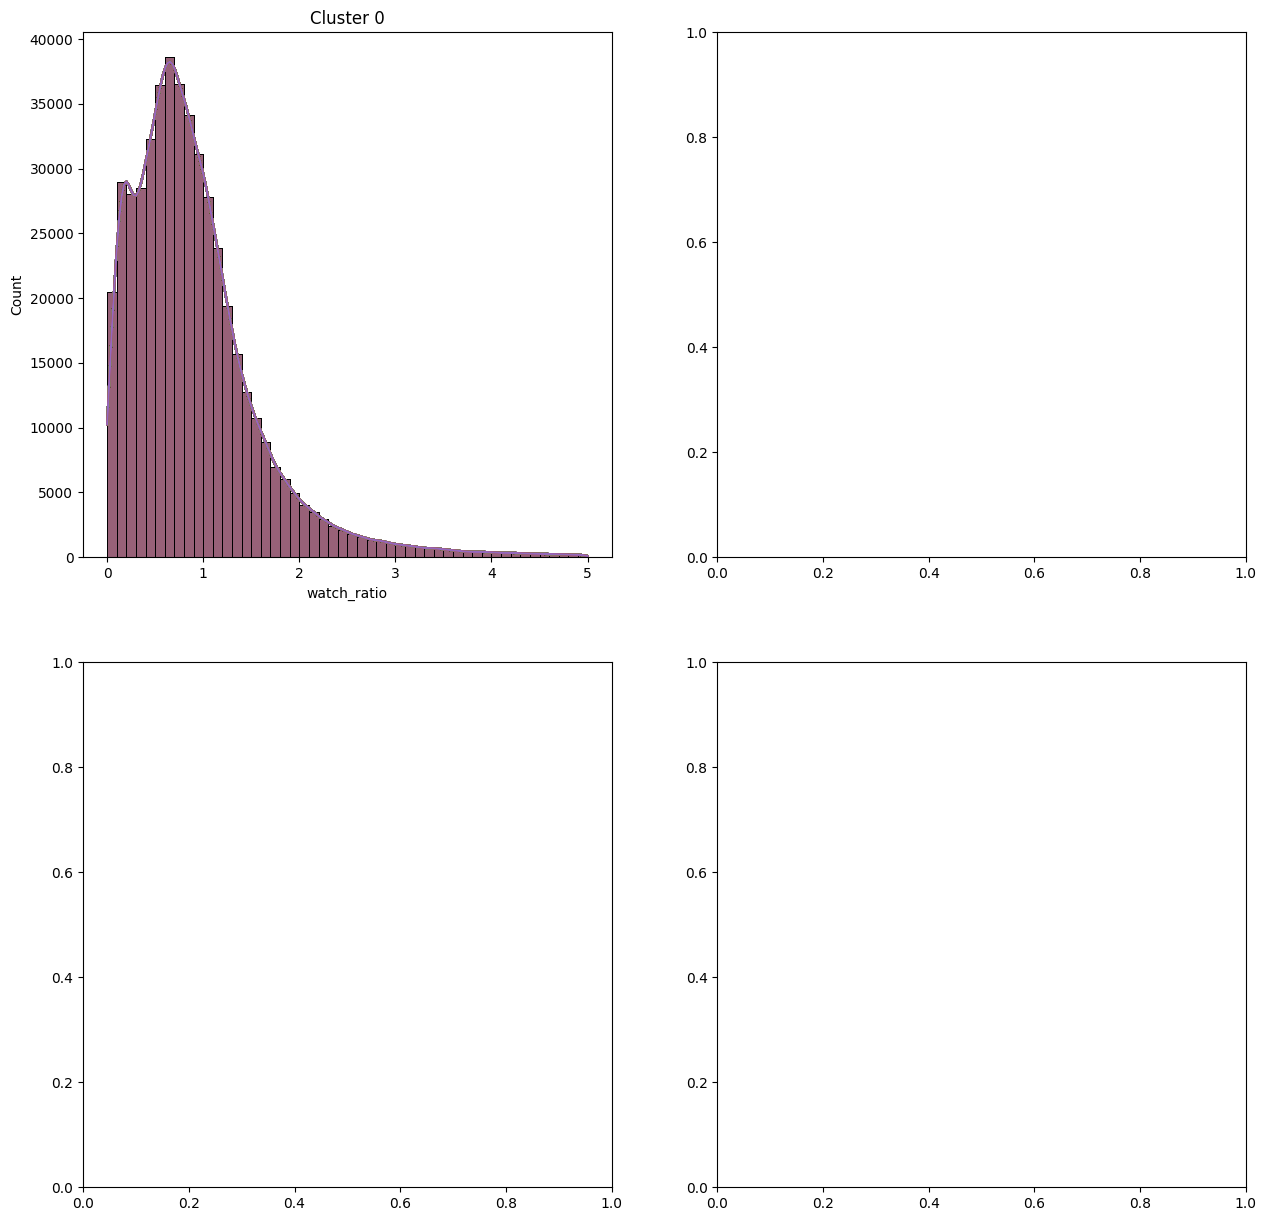

In [29]:
# Plot the watch ratio distribution for in training data
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for cluster in sorted(train_processed['cluster']):
    watch_ratios = train_processed[train_processed['cluster'] == cluster]['watch_ratio']
    sns.histplot(watch_ratios, bins=50, kde=True, ax=axs[cluster // 2, cluster % 2])
    axs[cluster // 2, cluster % 2].set_title(f"Cluster {cluster}")

plt.title("Watch Ratio Distribution for Training Data")
plt.show()

### Predicted

In [ ]:
# Plot the watch ratio distribution for each cluster
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for cluster in sorted(watch_ratio_predictions.keys()):
    sns.histplot(watch_ratio_predictions[cluster]['watch_ratio'], kde=True, bins=50, ax=axs[cluster // 2, cluster % 2])
    axs[cluster // 2, cluster % 2].set_title(f'Cluster {cluster}')

plt.title("Watch Ratio Distribution for Predicted Data")
plt.show()

## Backup

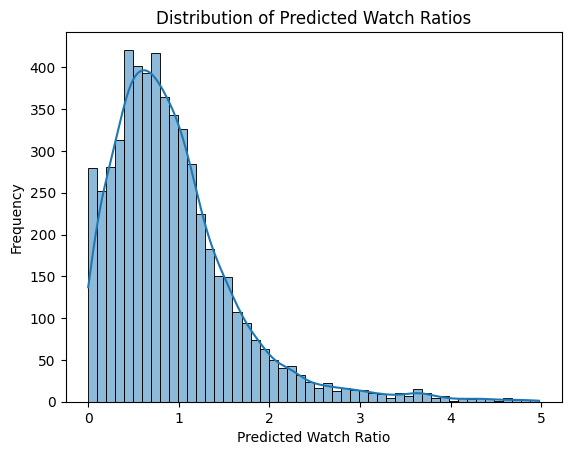

In [57]:
# Actual watch ratio distribution of first users with encoded IDs 0, 1, 2
test2 = train_processed

test2 = test2[test2['user_id'].isin(set(watch_ratio_predictions[0]['user_id']))]

sns.histplot(test2['watch_ratio'], bins=50, kde=True)
plt.title("Distribution of Predicted Watch Ratios")
plt.xlabel("Predicted Watch Ratio")
plt.ylabel("Frequency")
plt.show()

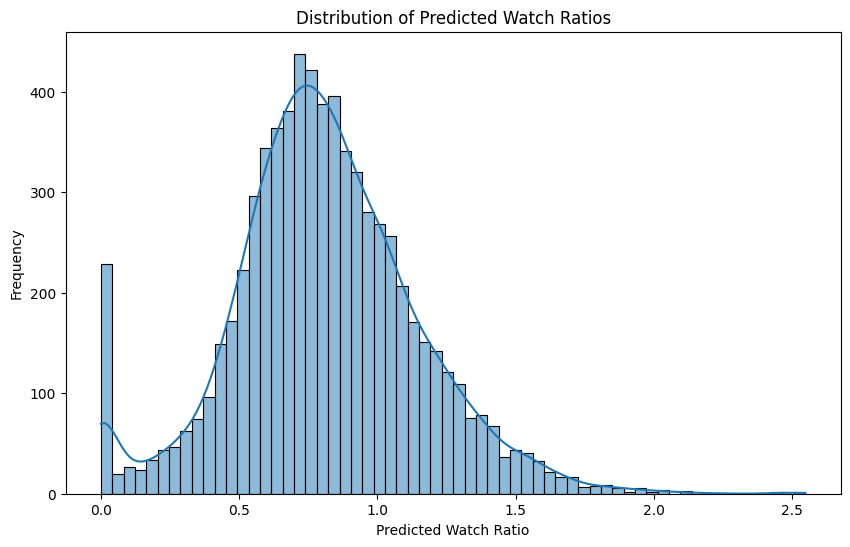

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(watch_ratio_predictions[0]['watch_ratio'], kde=True)
plt.title("Distribution of Predicted Watch Ratios")
plt.xlabel("Predicted Watch Ratio")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# class NCF(nn.Module):
#     def __init__(self, num_users, num_videos, embedding_dim, num_user_features, num_video_features):
#         super(NCF, self).__init__()
        
#         # GMF Components for embeddings
#         self.user_embeddings_gmf = nn.Embedding(num_users, embedding_dim)
#         self.video_embeddings_gmf = nn.Embedding(num_videos, embedding_dim)

#         # MLP Components for embeddings
#         self.user_embeddings_mlp = nn.Embedding(num_users, embedding_dim)
#         self.video_embeddings_mlp = nn.Embedding(num_videos, embedding_dim)

#         # MLP layers for user and video embeddings
#         self.fc1_mlp = nn.Linear(2 * embedding_dim + num_user_features + num_video_features, 128)
#         self.fc2_mlp = nn.Linear(128, 64)

#         # Final layers combining GMF, MLP for embeddings, and additional features
#         self.fc1_combined = nn.Linear(embedding_dim + 64, 128)
#         self.fc2_combined = nn.Linear(128, 1)

#     def forward(self, user_id, video_id, user_features, video_features, dropout=0.5):
#         ##### GMF Embedding branch
#         user_emb_gmf = self.user_embeddings_gmf(user_id)
#         video_emb_gmf = self.video_embeddings_gmf(video_id)
#         gmf_output = user_emb_gmf * video_emb_gmf   # dimension: (batch_size, embedding_dim)

#         ##### MLP Embedding branch
#         user_emb_mlp = self.user_embeddings_mlp(user_id)
#         video_emb_mlp = self.video_embeddings_mlp(video_id)

#         mlp_input = torch.cat([user_emb_mlp, video_emb_mlp, user_features, video_features], dim=-1) 

#         # First fully connected layer with BatchNorm and ReLU
#         mlp_output = self.fc1_mlp(mlp_input)
#         # if self.training:
#         #     mlp_output = nn.BatchNorm1d(128)(mlp_output)
#         mlp_output = torch.relu(mlp_output)
#         mlp_output = nn.Dropout(dropout)(mlp_output)

#         # Second fully connected layer with BatchNorm and ReLU
#         mlp_output = self.fc2_mlp(mlp_output)
#         # if self.training:
#         #     mlp_output = nn.BatchNorm1d(64)(mlp_output)
#         mlp_output = torch.relu(mlp_output)
#         mlp_output = nn.Dropout(dropout)(mlp_output)

#         ##### Combine GMF, MLP
#         combined_input = torch.cat([gmf_output, mlp_output], dim=-1)
#         combined_output = self.fc1_combined(combined_input)
#         # if self.training:
#         #     combined_output = nn.BatchNorm1d(128)(combined_output)
#         combined_output = torch.relu(combined_output)
#         combined_output = nn.Dropout(dropout)(combined_output)

#         ##### Scale wach_ratio to range [0, 5]
#         combined_output = self.fc2_combined(combined_output)
#         combined_output = torch.relu(combined_output)

#         return combined_output.squeeze()

In [ ]:
# Parameters
num_epochs = 10
learning_rate = 0.001

# Instantiate the model
embedding_dim = 64  
num_users = len(dataset_train.user_encoder.classes_)
num_videos = len(dataset_train.video_encoder.classes_)
num_user_features = len(dataset_train.user_feature_cols)
num_video_features = len(dataset_train.video_feature_cols)

model = NCF(num_users=num_users, num_videos=num_videos, embedding_dim=embedding_dim,
            num_user_features=num_user_features, num_video_features=num_video_features)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to {device}")

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for user_ids, video_ids, user_features, video_features, watch_ratios in train_loader:
        # Move data to device
        user_ids = user_ids.to(device)
        video_ids = video_ids.to(device)
        user_features = user_features.to(device)
        video_features = video_features.to(device)
        watch_ratios = watch_ratios.to(device)

        # Forward pass
        outputs = model(user_ids, video_ids, user_features, video_features, dropout=0.3)
        loss = criterion(outputs, watch_ratios)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for reporting
        total_loss += loss.item()

    # Print loss for each epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete!")

Model moved to cpu
Epoch [1/10], Loss: 0.3981
Epoch [2/10], Loss: 0.3657
Epoch [3/10], Loss: 0.3594
Epoch [4/10], Loss: 0.3549
Epoch [5/10], Loss: 0.3520
Epoch [6/10], Loss: 0.3495
Epoch [7/10], Loss: 0.3467
Epoch [8/10], Loss: 0.3446
Epoch [9/10], Loss: 0.3422
Epoch [10/10], Loss: 0.3395
Training complete!


In [ ]:
# print final gradient values
model.state_dict()

OrderedDict([('user_embeddings_gmf.weight',
              tensor([[-0.3946,  0.2840,  1.8574,  ..., -0.1764, -0.7954,  1.5967],
                      [ 0.8641, -1.5359,  1.2098,  ...,  0.6048, -0.2083, -1.0418],
                      [-0.0155, -0.2496,  1.3121,  ..., -0.6592, -1.6164,  1.5715],
                      ...,
                      [-1.4487, -0.4518,  0.6253,  ...,  1.5136, -0.1145, -0.3402],
                      [ 0.5050, -0.2959, -0.8104,  ..., -0.9298, -1.1600,  0.1400],
                      [ 1.2551, -1.9156,  0.2349,  ...,  1.0009,  0.3798,  1.1823]])),
             ('video_embeddings_gmf.weight',
              tensor([[ 0.2426,  0.8590,  0.0939,  ...,  0.0105,  1.0146, -0.9827],
                      [ 0.3618, -1.4757,  0.7942,  ...,  1.3524,  1.1555,  0.8468],
                      [-1.5200,  1.0086, -0.9826,  ..., -0.6520, -0.0723, -0.0965],
                      ...,
                      [ 0.4417,  0.1060,  1.5396,  ...,  0.9962,  0.3305, -0.0251],
              

Generating the watch_ratio matrix

In [ ]:
def generate_watch_ratio_matrix(model, num_users, num_videos, user_features, video_features, embedding_dim):
    """
    Generate the watch ratio matrix with predicted watch ratios for each user-video pair.
    
    Args:
    - model: The trained NCF model.
    - num_users: The number of unique users.
    - num_videos: The number of unique videos.
    - user_features: Preprocessed user features.
    - video_features: Preprocessed video features.

    Returns:
    - watch_ratio_matrix: A matrix of shape (num_users, num_videos) with predicted watch ratios.
    """
    
    model.eval()  # Set model to evaluation mode
    
    # Initialise the watch_ratio_matrix (num_users x num_videos)
    watch_ratio_matrix = torch.zeros((num_users, num_videos), dtype=torch.float32)
    
    # Iterate through all user-video pairs
    for user_id in range(3):
    # for user_id in range(num_users):
        for video_id in range(num_videos):
            user_tensor = torch.tensor([user_id], dtype=torch.long)
            video_tensor = torch.tensor([video_id], dtype=torch.long)
            
            user_feature_tensor = user_features[user_id].unsqueeze(0)  # (1, num_user_features)
            video_feature_tensor = video_features[video_id].unsqueeze(0)  # (1, num_video_features)
            
            # Get the predicted watch ratio
            with torch.no_grad():
                predicted_watch_ratio = model(user_tensor, video_tensor, user_feature_tensor, video_feature_tensor, dropout=0.3)
            
            # Store the predicted watch ratio in the matrix
            watch_ratio_matrix[user_id, video_id] = predicted_watch_ratio.item()
    
    return watch_ratio_matrix

In [ ]:
watch_ratio_matrix = generate_watch_ratio_matrix(model, num_users, num_videos, dataset_train.user_features, dataset_train.video_features, embedding_dim)

In [ ]:
print(num_users, num_videos)
watch_ratio_matrix.shape

269 2360


torch.Size([269, 2360])

In [ ]:
# Convert matrix to DataFrame
watch_ratio_df = pd.DataFrame(watch_ratio_matrix.numpy())

# Pivot the DataFrame
watch_ratio_df = watch_ratio_df.stack().reset_index()
watch_ratio_df.columns = ['user_id', 'video_id', 'watch_ratio']

watch_ratio_df = watch_ratio_df[watch_ratio_df['user_id'] < 3]
watch_ratio_df

,user_id,video_id,watch_ratio
0,0,0,1.563591
1,0,1,1.258181
2,0,2,0.872372
3,0,3,1.139620
4,0,4,0.850369
...,...,...,...
7075,2,2355,1.057613
7076,2,2356,0.720386
7077,2,2357,0.916240
7078,2,2358,0.677980
